# **Setup**

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras as tfk

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow_hub import KerasLayer

from tf_keras.preprocessing import image
from tf_keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tf_keras.preprocessing.image import ImageDataGenerator

os.environ["KERAS_BACKEND"] = "tensorflow"

import warnings
warnings.filterwarnings("ignore")

In [ ]:
TRAIN = "/kaggle/input/hology-train-aug-dataset/train_augm"
TEST = "/kaggle/input/hology-clothes-dataset/dataset/test_end"
TRAIN_CSV = '/kaggle/input/hology-train-aug-dataset/dataset_augmented.csv'
TEST_CSV = '/kaggle/input/hology-clothes-dataset/sample_submission.csv'

IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64
RANDOM_STATE = 42

# **Prepared Dataset**

In [3]:
train_df = pd.read_csv(TRAIN_CSV)

train_df['id'] = train_df['id'].astype('str') + '.png'
train_df['jenis'] = train_df['jenis'].astype('str')
train_df['warna'] = train_df['warna'].astype('str')

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=RANDOM_STATE)
len(train_data), len(val_data)

(3108, 777)

In [4]:
test_df = pd.read_csv(TEST_CSV)

test_df['id'] = test_df['id'].astype('str') + '.png'
test_df['jenis'] = test_df['jenis'].astype('str')
test_df['warna'] = test_df['warna'].astype('str')

# **BigTransfer-ViT**

In [5]:
def BigTransferViT(pretrained, classes):
    tfk.backend.clear_session()

    input = tfk.layers.Input(shape=(224, 224, 3))

    x = KerasLayer(
        pretrained,
        trainable=False
    )(input)
    x = tfk.layers.Flatten()(x)
    x = tfk.layers.Dropout(0.2)(x)

    vit = KerasLayer(
        "/kaggle/input/vision-transformer/tensorflow2/vit-s16-classification/1",
        trainable=False
    )(input)
    vit = tfk.layers.Flatten()(vit)
    vit = tfk.layers.Dropout(0.2)(vit)

    concat = tfk.layers.Concatenate()([x, vit])
    
    output = tfk.layers.Dense(classes, activation='softmax')(concat)
    model = tfk.Model(inputs=input, outputs=output)
    
    model.compile(
        optimizer=tfk.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7,
        ),
        loss='categorical_crossentropy',
        metrics='accuracy'
    )
    
    return model

# **Define Evaluate Function**

In [6]:
def plot_history(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
    ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')

    ax[1].set_title('Training/Validation Loss vs. Epochs')
    ax[1].plot(train_loss, 'o-', label='Train Loss')
    ax[1].plot(val_loss, 'o-', label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(model, model_name, generator): 
    y_pred = np.argmax(model.predict(generator), axis=1).tolist()
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [14]:
def run_experiment(train, val, num_classes, cw):
    bit = BigTransferViT("/kaggle/input/bit/tensorflow2/m-r50x1/1", num_classes)
    bit.summary()
    
    bit_history = bit.fit(
        train, epochs=50,
        validation_data=val,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        class_weight=cw
    )
    
    score = bit.evaluate(val)
    print('Val Loss: ', score[0])
    print('Val Accuracy: ', score[1])
    
    return bit_history, bit

# **Training Jenis**

In [9]:
train_jenis = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN,  
    x_col='id',  
    y_col='jenis',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_STATE
)

val_jenis = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe=val_data,
    directory=TRAIN,  
    x_col='id',  
    y_col='jenis',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_STATE
)

test_jenis = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=TEST,
    x_col='id',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_STATE
)

Found 3108 validated image filenames belonging to 2 classes.
Found 777 validated image filenames belonging to 2 classes.
Found 334 validated image filenames.


In [10]:
train_labels = train_jenis.classes

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight = dict(enumerate(class_weight))
class_weight

{0: 0.8144654088050315, 1: 1.295}

In [15]:
history_jenis, bit_jenis = run_experiment(train_jenis, val_jenis, 2, class_weight)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 2048)                 2350035   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 keras_layer_1 (KerasLayer)  (None, 1000)                 2205066   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

I0000 00:00:1730033518.096187     122 service.cc:145] XLA service 0x55fd17400d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730033518.096253     122 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730033521.193993     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 76s 794ms/step - loss: 0.3335 - accuracy: 0.9080 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 2/50
49/49 [==============================] - 22s 455ms/step - loss: 0.0712 - accuracy: 0.9772 - val_loss: 0.0249 - val_accuracy: 0.9923
Epoch 3/50
49/49 [==============================] - 22s 455ms/step - loss: 0.0309 - accuracy: 0.9875 - val_loss: 0.0177 - val_accuracy: 0.9936
Epoch 4/50
49/49 [==============================] - 22s 455ms/step - loss: 0.0298 - accuracy: 0.9887 - val_loss: 0.0088 - val_accuracy: 0.9961
Epoch 5/50
49/49 [==============================] - 22s 451ms/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0098 - val_accuracy: 0.9961
Epoch 6/50
49/49 [==============================] - 22s 454ms/step - loss: 0.0144 - accuracy: 0.9939 - val_loss: 0.0057 - val_accuracy: 0.9974
Epoch 7/50
49/49 [==============================] - 22s 452ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.0060 - val_accuracy: 0.9961
Epoch 8/50

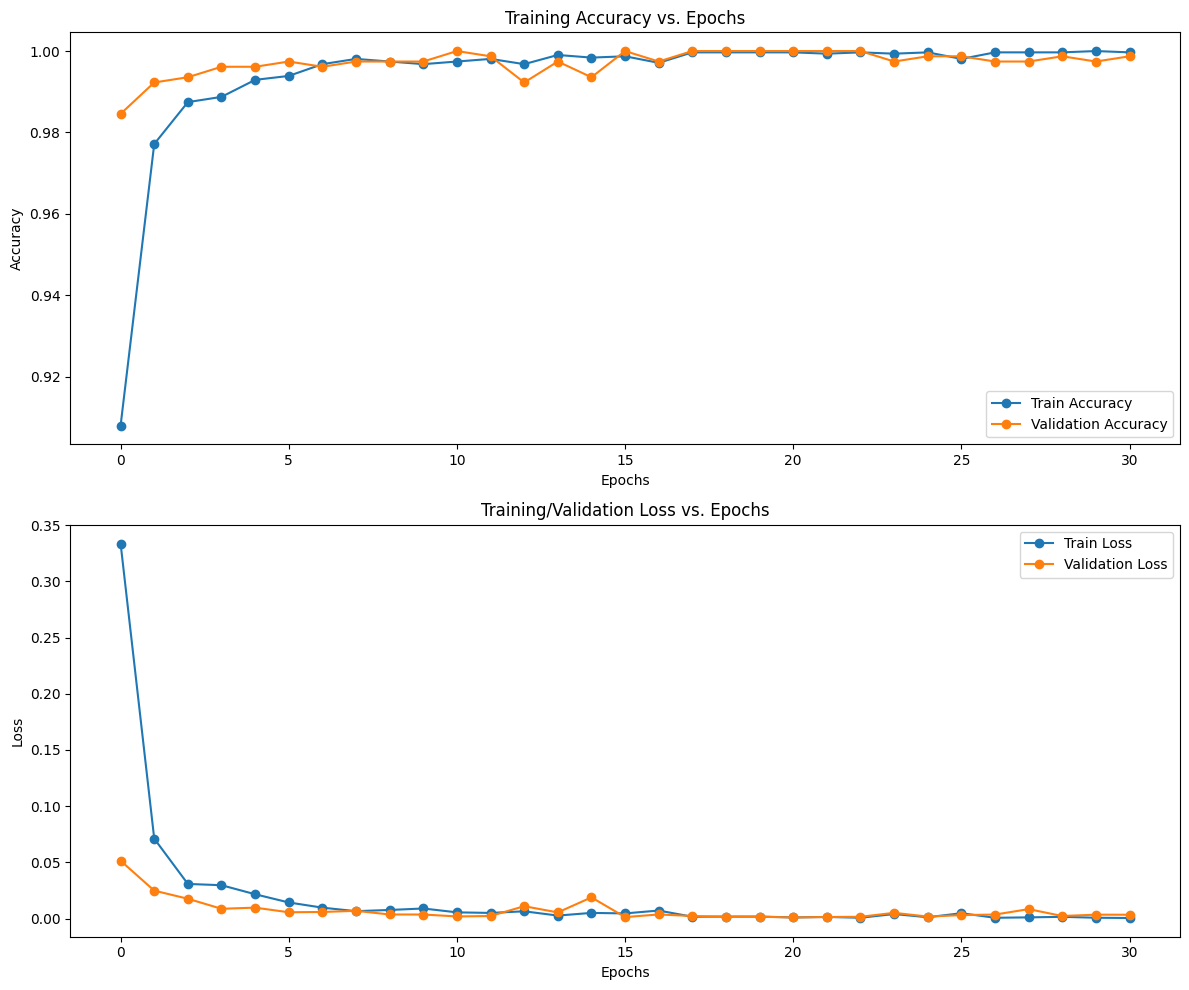

In [17]:
plot_history(history_jenis)

13/13 [==============================] - 6s 354ms/step


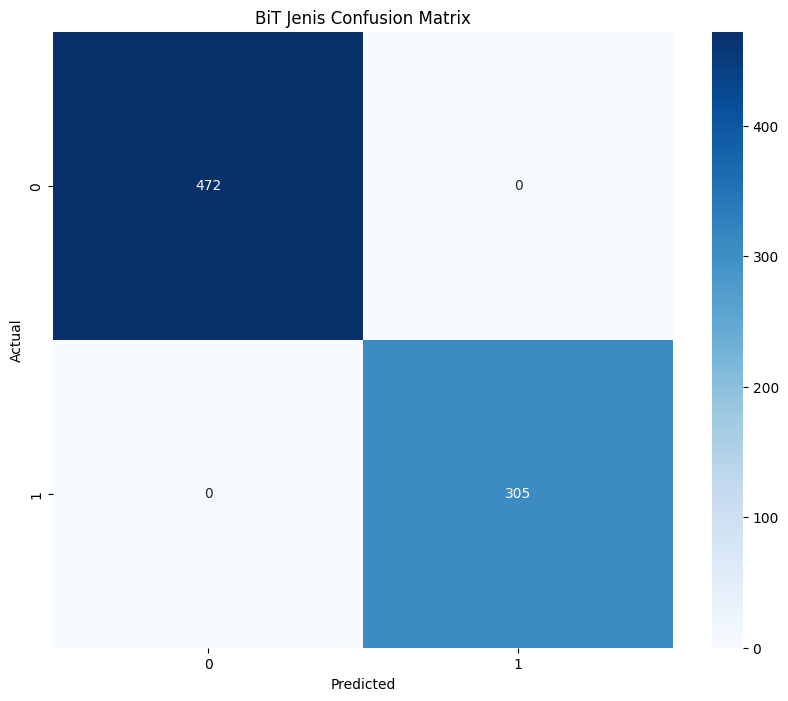

In [27]:
plot_confusion_matrix(bit_jenis, "BiT Jenis", val_jenis)

In [18]:
bit_jenis.save('bit_jenis.keras')

In [19]:
jenis_pred = np.argmax(bit_jenis.predict(test_jenis), axis=1).tolist()
test_df['jenis'] = jenis_pred
test_df

6/6 [==============================] - 6s 840ms/step


,id,jenis,warna
0,778.png,0,nan
1,779.png,1,nan
2,780.png,1,nan
3,781.png,0,nan
4,782.png,1,nan
...,...,...,...
329,1107.png,1,nan
330,1108.png,0,nan
331,1109.png,0,nan
332,1110.png,1,nan


# **Training Warna**

In [20]:
train_warna = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN,  
    x_col='id',  
    y_col='warna',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_STATE
)

val_warna = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe=val_data,
    directory=TRAIN,  
    x_col='id',  
    y_col='warna',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_STATE
)

test_warna = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=TEST,
    x_col='id',
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_STATE
)

Found 3108 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.
Found 334 validated image filenames.


In [21]:
train_labels = train_warna.classes

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight = dict(enumerate(class_weight))
class_weight

{0: 1.3141649048625792,
 1: 1.2308910891089109,
 2: 0.9236255572065379,
 3: 0.6868508287292817,
 4: 1.126086956521739}

In [22]:
history_warna, bit_warna = run_experiment(train_warna, val_warna, 5, class_weight)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 2048)                 2350035   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 keras_layer_1 (KerasLayer)  (None, 1000)                 2205066   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

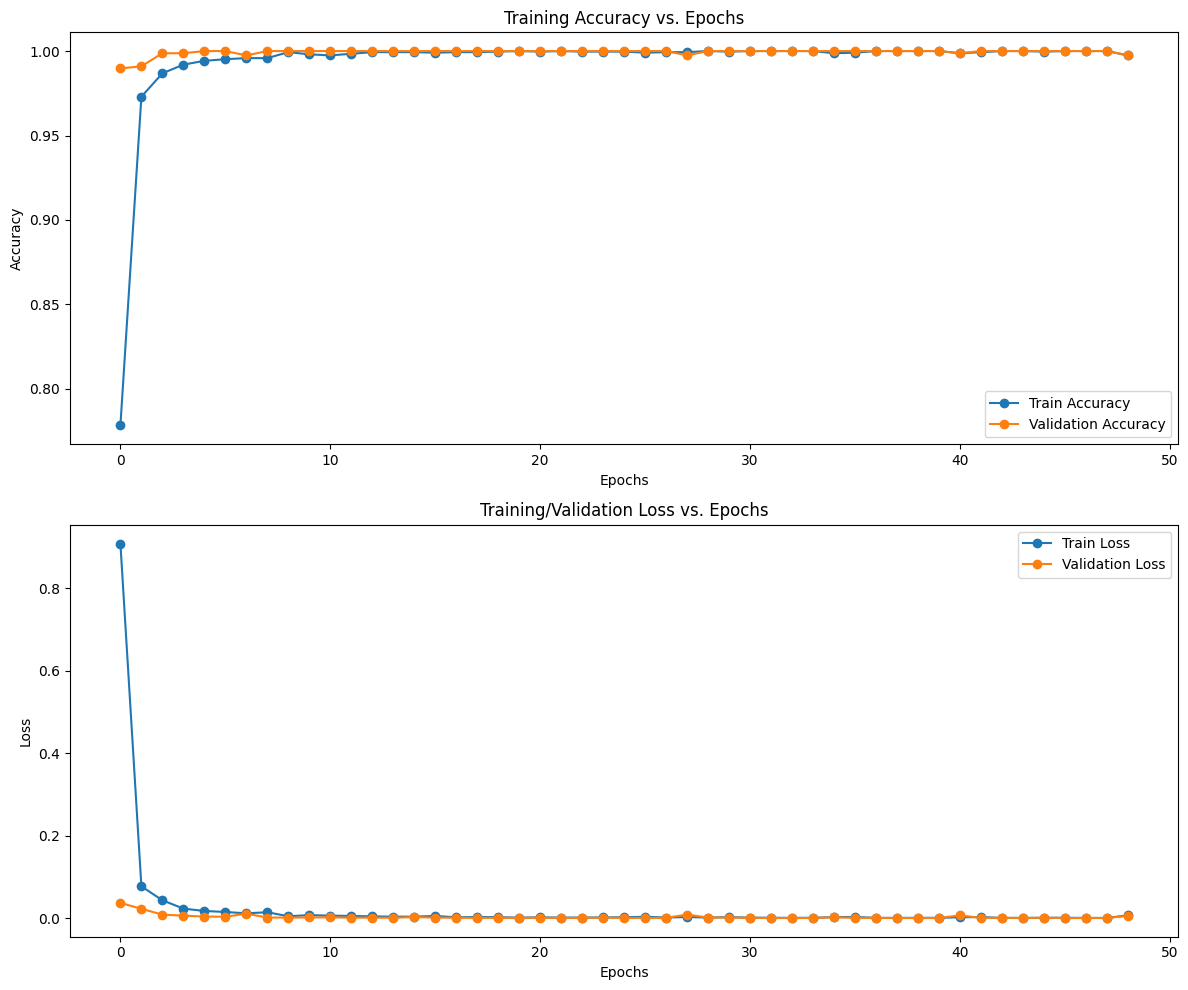

In [24]:
plot_history(history_warna)

13/13 [==============================] - 6s 354ms/step


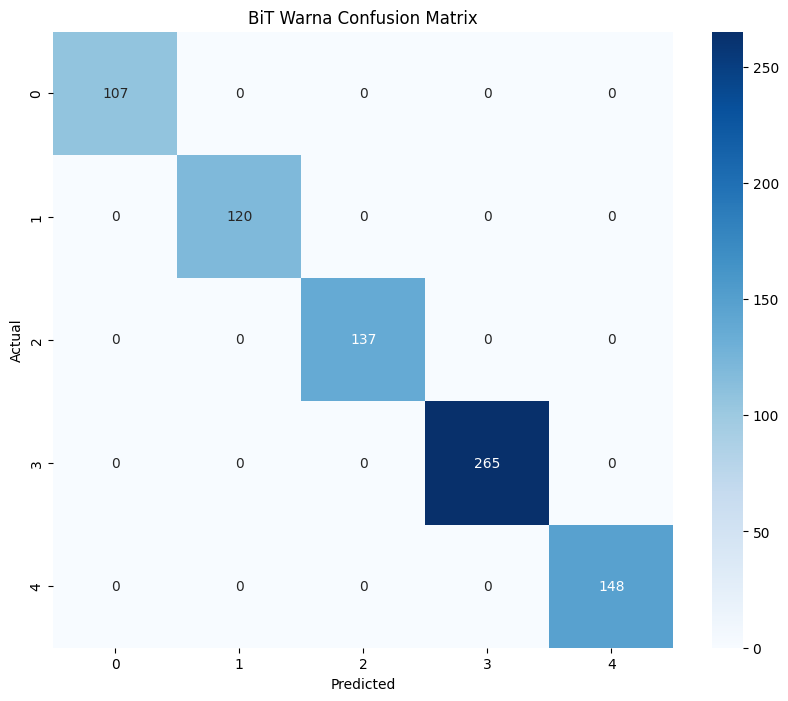

In [25]:
plot_confusion_matrix(bit_warna, "BiT Warna", val_warna)

In [28]:
bit_warna.save('bit_warna.keras')

In [29]:
warna_pred = np.argmax(bit_warna.predict(test_warna), axis=1).tolist()
test_df['warna'] = warna_pred
test_df

6/6 [==============================] - 2s 359ms/step


,id,jenis,warna
0,778.png,0,3
1,779.png,1,3
2,780.png,1,2
3,781.png,0,1
4,782.png,1,3
...,...,...,...
329,1107.png,1,0
330,1108.png,0,2
331,1109.png,0,2
332,1110.png,1,3


In [30]:
test_df.to_csv('test_final.csv', index=False)

# **Testing**

1/1 [==============================] - 0s 28ms/step


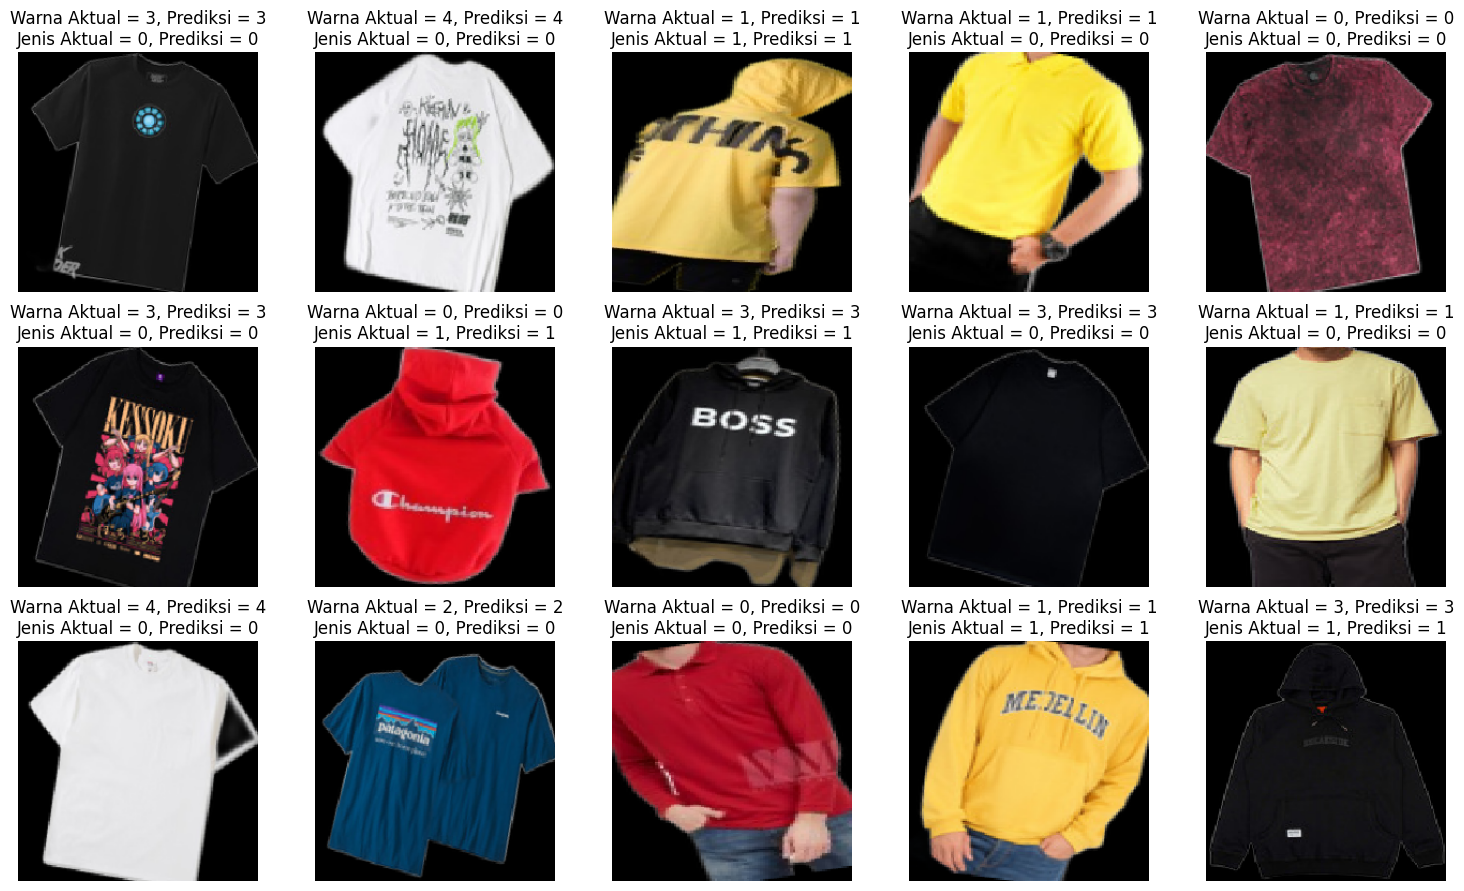

In [41]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array, mode='tf', data_format=None)
    return img, img_array

def visualize_predictions(data: pd.DataFrame, pathOfImage: str, model_jenis, model_warna, num_images=15):
    plt.figure(figsize=(15, 9))

    sample_data = data.sample(n=num_images)

    for i, row in enumerate(sample_data.itertuples()):
        img_path = os.path.join(pathOfImage, str(row.id))
        img, img_array = load_and_preprocess_image(img_path)

        pred_jenis = np.argmax(model_jenis.predict(img_array), axis=1)[0]
        pred_warna = np.argmax(model_warna.predict(img_array), axis=1)[0]

        actual_jenis = int(row.jenis)
        actual_warna = int(row.warna)

        label_color = 'black'
        if actual_jenis != pred_jenis or actual_warna != pred_warna:
            label_color = 'red'

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"Warna Aktual = {actual_warna}, Prediksi = {pred_warna}\n"
            f"Jenis Aktual = {actual_jenis}, Prediksi = {pred_jenis}", 
            color=label_color
        )

    plt.tight_layout()
    plt.show()

visualize_predictions(train_data, TRAIN, bit_jenis, bit_warna)